# NLP Standard Project - Identifying Human Values behind Arguments

*Objective*: given a textual argument and a human value category, classify whether or not the argument draws on that category.

Arguments are given as premise text, conclusion text, and binary
stance of the premise to the conclusion (“in favor of” or “against”). 20 value categories compiled from the social science literature. It’s your choice to focus on one, a subset, or all values in arguments.

## Imports

*N.B.* `zenodo-get` is a Python package that provides a simple way to download data from the Zenodo reository. 

In [1]:
!pip install transformers
!pip install evaluate
!pip install zenodo-get
!zenodo_get 10.5281/zenodo.7550385

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 13.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 19.5 MB/s eta 0:00:00

In [2]:
import torch, re, nltk, transformers, warnings, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from functools import reduce
from transformers import AutoTokenizer, AutoModelForSequenceClassification, EvalPrediction, TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset, DatasetDict
from typing import List, Callable
from sklearn.metrics import f1_score, precision_score, recall_score

warnings.filterwarnings('ignore')

We check whether a GPU is available on the system and, if so, we run the code on the GPU by assigning `cuda` to the device variable; otherwise, we assign `cpu`.



In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Arranging the Data

Once the data have been downloaded from the Zenodo repository, we merge the arguments and their respective labels into a single dataset. We do this for both training and test set.

*N.B.* The test set has not been labelled so we adopt the validation set as test one.

In [4]:
arguments_train_path = 'arguments-training.tsv'
arguments_val_path = 'arguments-validation.tsv'
arguments_test_path = 'arguments-validation-zhihu.tsv'

labels_train_path = 'labels-training.tsv'
labels_val_path = 'labels-validation.tsv'
labels_test_path = 'labels-validation-zhihu.tsv'

In [5]:
df_arguments_train = pd.read_csv(arguments_train_path, sep='\t')
df_labels_train = pd.read_csv(labels_train_path, sep='\t')
df_train = pd.merge(df_arguments_train, df_labels_train, on='Argument ID')

df_arguments_val = pd.read_csv(arguments_val_path, sep='\t')
df_labels_val = pd.read_csv(labels_val_path, sep='\t')
df_val = pd.merge(df_arguments_val, df_labels_val, on='Argument ID')

df_arguments_test = pd.read_csv(arguments_test_path, sep='\t')
df_labels_test = pd.read_csv(labels_test_path, sep='\t')
df_test = pd.merge(df_arguments_test, df_labels_test, on='Argument ID')

In [6]:
df_train.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [7]:
df_val.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01001,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01012,The use of public defenders should be mandatory,in favor of,the use of public defenders should be mandator...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,A02001,Payday loans should be banned,in favor of,payday loans create a more impoverished societ...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,A02002,Surrogacy should be banned,against,Surrogacy should not be banned as it is the wo...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A02009,Entrapment should be legalized,against,entrapment is gravely immoral and against huma...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1


In [8]:
df_test.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,C26001,We should abolish the 996 overtime system,in favor of,China's 996 overtime system is very inefficien...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,C26002,We should abolish the 996 overtime system,in favor of,China's 996 overtime system leaves you with no...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,C26003,We should abolish the 996 overtime system,against,"For the poor people, if they can go to the Int...",0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,C26004,We should abolish the 996 overtime system,in favor of,China's 996 overtime system violates labor laws.,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,C26005,We should abolish the 996 overtime system,against,Corporate management seeks to maximize profits...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Exploring the Data

In [9]:
# check the distribution of the data
print("Shape of the Training Dataset: ", df_train.shape)
print()
print("Shape of the Validation Dataset: ", df_val.shape)
print()
print("Shape of the Test Dataset: ", df_test.shape)
print()

Shape of the Training Dataset:  (5393, 24)

Shape of the Validation Dataset:  (1896, 24)

Shape of the Test Dataset:  (100, 24)



In [10]:
columns = df_train.columns.tolist()

print("Distribution of the classes for the training set: ")
print()
for c in columns[4:]:
  print(df_train[c].value_counts())
  print()

Distribution of the classes for the training set: 

0    4405
1     988
Name: Self-direction: thought, dtype: int64

0    3998
1    1395
Name: Self-direction: action, dtype: int64

0    5146
1     247
Name: Stimulation, dtype: int64

0    5221
1     172
Name: Hedonism, dtype: int64

0    3881
1    1512
Name: Achievement, dtype: int64

0    4783
1     610
Name: Power: dominance, dtype: int64

0    4768
1     625
Name: Power: resources, dtype: int64

0    5011
1     382
Name: Face, dtype: int64

0    3393
1    2000
Name: Security: personal, dtype: int64

0    3665
1    1728
Name: Security: societal, dtype: int64

0    4825
1     568
Name: Tradition, dtype: int64

0    4216
1    1177
Name: Conformity: rules, dtype: int64

0    5186
1     207
Name: Conformity: interpersonal, dtype: int64

0    4998
1     395
Name: Humility, dtype: int64

0    4061
1    1332
Name: Benevolence: caring, dtype: int64

0    4587
1     806
Name: Benevolence: dependability, dtype: int64

0    3312
1    2081
Name:

In [11]:
print("Distribution of the classes for the validation set: ")
print()
for c in columns[4:]:
  print(df_val[c].value_counts())
  print()

Distribution of the classes for the validation set: 

0    1645
1     251
Name: Self-direction: thought, dtype: int64

0    1400
1     496
Name: Self-direction: action, dtype: int64

0    1758
1     138
Name: Stimulation, dtype: int64

0    1793
1     103
Name: Hedonism, dtype: int64

0    1321
1     575
Name: Achievement, dtype: int64

0    1732
1     164
Name: Power: dominance, dtype: int64

0    1764
1     132
Name: Power: resources, dtype: int64

0    1766
1     130
Name: Face, dtype: int64

0    1137
1     759
Name: Security: personal, dtype: int64

0    1408
1     488
Name: Security: societal, dtype: int64

0    1724
1     172
Name: Tradition, dtype: int64

0    1441
1     455
Name: Conformity: rules, dtype: int64

0    1836
1      60
Name: Conformity: interpersonal, dtype: int64

0    1769
1     127
Name: Humility, dtype: int64

0    1263
1     633
Name: Benevolence: caring, dtype: int64

0    1628
1     268
Name: Benevolence: dependability, dtype: int64

0    1209
1     687
Nam

In [12]:
print("Distribution of the classes for the test set: ")
print()
for c in columns[4:]:
  print(df_test[c].value_counts())
  print()

Distribution of the classes for the test set: 

0    94
1     6
Name: Self-direction: thought, dtype: int64

0    89
1    11
Name: Self-direction: action, dtype: int64

0    100
Name: Stimulation, dtype: int64

0    98
1     2
Name: Hedonism, dtype: int64

0    61
1    39
Name: Achievement, dtype: int64

0    99
1     1
Name: Power: dominance, dtype: int64

0    81
1    19
Name: Power: resources, dtype: int64

0    99
1     1
Name: Face, dtype: int64

0    70
1    30
Name: Security: personal, dtype: int64

0    69
1    31
Name: Security: societal, dtype: int64

0    100
Name: Tradition, dtype: int64

0    85
1    15
Name: Conformity: rules, dtype: int64

0    99
1     1
Name: Conformity: interpersonal, dtype: int64

0    95
1     5
Name: Humility, dtype: int64

0    88
1    12
Name: Benevolence: caring, dtype: int64

0    97
1     3
Name: Benevolence: dependability, dtype: int64

0    79
1    21
Name: Universalism: concern, dtype: int64

0    92
1     8
Name: Universalism: nature, dtyp

Training set labels distribution


<Figure size 1500x1000 with 0 Axes>

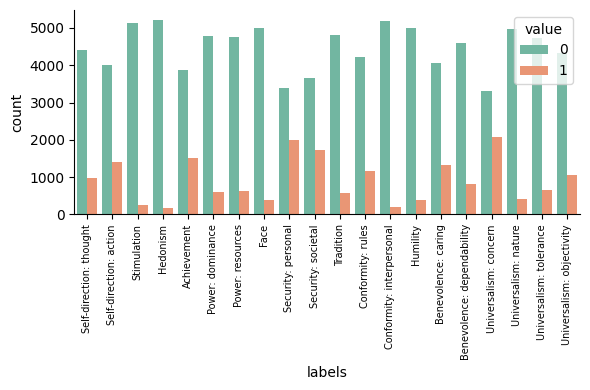

In [13]:
print("Training set labels distribution")
plt.figure(figsize=(15,10))

# create a DataFrame with all the columns to be plotted
plot_data = pd.melt(df_train[columns[4:]], var_name='labels')

# plot the data with catplot
g = sns.catplot(data=plot_data, 
                x='labels', 
                hue='value', 
                kind='count', 
                height=4, 
                aspect=1.5, 
                palette='Set2', 
                legend_out=False)

# rotate the x-axis tick labels and set the font size
g.set_xticklabels(rotation=90, fontsize=7)

plt.tight_layout()
plt.show()

Validation set labels distribution


<Figure size 1500x1000 with 0 Axes>

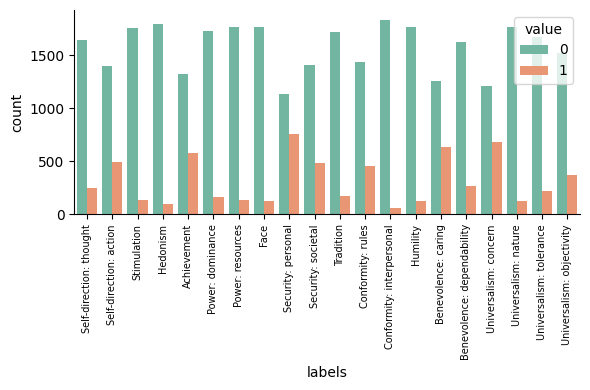

In [14]:
print("Validation set labels distribution")
plt.figure(figsize=(15,10))

# create a DataFrame with all the columns to be plotted
plot_data = pd.melt(df_val[columns[4:]], var_name='labels')

# plot the data with catplot
g = sns.catplot(data=plot_data, 
                x='labels', 
                hue='value', 
                kind='count', 
                height=4, 
                aspect=1.5, 
                palette='Set2', 
                legend_out=False)

# rotate the x-axis tick labels and set the font size
g.set_xticklabels(rotation=90, fontsize=7)

plt.tight_layout()
plt.show()

Test set labels distribution


<Figure size 1500x1000 with 0 Axes>

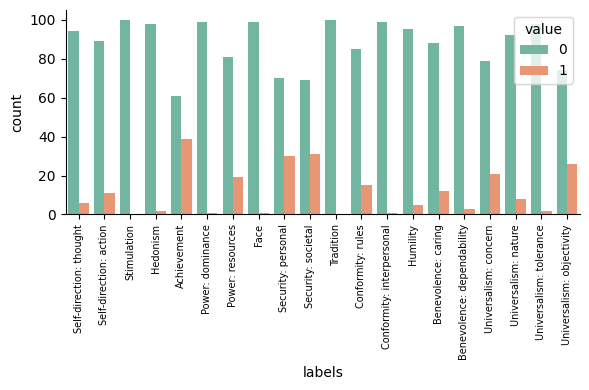

In [15]:
print("Test set labels distribution")
plt.figure(figsize=(15,10))

# create a DataFrame with all the columns to be plotted
plot_data = pd.melt(df_test[columns[4:]], var_name='labels')

# plot the data with catplot
g = sns.catplot(data=plot_data, 
                x='labels', 
                hue='value', 
                kind='count', 
                height=4, 
                aspect=1.5, 
                palette='Set2', 
                legend_out=False)

# rotate the x-axis tick labels and set the font size
g.set_xticklabels(rotation=90, fontsize=7)

plt.tight_layout()
plt.show()

## Preprocessing the Data

We decided to remove words "against" and "favor" from stopwords because they costituiscono our `Stance` thus they have to be used during the concatenation of columns `Conclusion`, `Stance` and `Premise`.

In [16]:
replace_by_space_re = re.compile('[/(){}\[\]\|@,;]')
good_symbols_re = re.compile('[^0-9a-z #+_]')
replace_multiple_spaces_re = re.compile(' +')
good_stopwords = ['favor','against']

try:
    stopwords = set(stopwords.words('english'))
    stopwords = stopwords - set(good_stopwords)
except LookupError:
    nltk.download('stopwords')
    stopwords = set(stopwords.words('english'))
    stopwords = stopwords - set(good_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    """
    return text.lower()
 
def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis, with spacing character
    """
    return replace_by_space_re.sub(' ', text)

def replace_br(text: str) -> str:
    """
    Replaces br characters
    """
    return text.replace('br', '')

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the good symbols list (check regular expression)
    """
    return good_symbols_re.sub('', text)
 
def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in stopwords])
 
def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    """
    return text.strip()

def replace_double_spaces(text: str) -> str:
    """
    Replaces special characters, such as paranthesis, with spacing character
    """
    return replace_multiple_spaces_re.sub(' ', text)

In [18]:
preprocessing_pipeline = [
                          lower,
                          replace_special_characters,
                          replace_br,
                          filter_out_uncommon_symbols,
                          remove_stopwords,
                          strip_text,
                          replace_double_spaces
                          ]

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    filter_methods = filter_methods if filter_methods is not None else preprocessing_pipeline
    return reduce(lambda txt, f: f(txt), filter_methods, text)

Once the pre-pocessing steps have been defined, we replace each sentence with its pre-processed version.

In [19]:
df_train['Conclusion'] = df_train['Conclusion'].apply(lambda txt: text_prepare(txt))
df_train['Stance'] = df_train['Stance'].apply(lambda txt: text_prepare(txt))
df_train['Premise'] = df_train['Premise'].apply(lambda txt: text_prepare(txt))

df_val['Conclusion'] = df_val['Conclusion'].apply(lambda txt: text_prepare(txt))
df_val['Stance'] = df_val['Stance'].apply(lambda txt: text_prepare(txt))
df_val['Premise'] = df_val['Premise'].apply(lambda txt: text_prepare(txt))

df_test['Conclusion'] = df_test['Conclusion'].apply(lambda txt: text_prepare(txt))
df_test['Stance'] = df_test['Stance'].apply(lambda txt: text_prepare(txt))
df_test['Premise'] = df_test['Premise'].apply(lambda txt: text_prepare(txt))

We print out the first five rows of each dataset to show the result of pre-processing.

In [20]:
df_train.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,ban human cloning,favor,ban human cloning cause huge issues bunch huma...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,ban fast food,favor,fast food banned really bad health costly,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A01006,end use economic sanctions,against,sometimes economic sanctions thing get corrupt...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,A01007,abolish capital punishment,against,capital punishment sometimes option keep crimi...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,ban factory farming,against,factory farming allows production cheap food n...,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [21]:
df_val.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01001,entrapment legalized,favor,entrapment serve easily capture wanted crimina...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01012,use public defenders mandatory,favor,use public defenders mandatory people dont mon...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,A02001,payday loans banned,favor,payday loans create impoverished society crazy...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,A02002,surrogacy banned,against,surrogacy banned womans right choose wishes an...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A02009,entrapment legalized,against,entrapment gravely immoral against human right...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1


In [22]:
df_test.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,C26001,abolish 996 overtime system,favor,chinas 996 overtime system inefficient enhanci...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,C26002,abolish 996 overtime system,favor,chinas 996 overtime system leaves room learn i...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,C26003,abolish 996 overtime system,against,poor people go internet factory chinas 996 ove...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,C26004,abolish 996 overtime system,favor,chinas 996 overtime system violates labor laws,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,C26005,abolish 996 overtime system,against,corporate management seeks maximize profits ch...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Tokenization

### Choosing the Max Length

To properly choose the max_length parameter of the tokenizer, you need to consider the maximum length of the input sequences that your downstream task requires or supports. This maximum length can vary depending on the task you are trying to solve, the available hardware resources, and the specific BERT model architecture you are using.

One way to choose the max_length parameter is to look at the distribution of the sentence lengths in your dataset and set the parameter to a value that covers the vast majority of the sentences. You can plot a histogram of the sentence lengths to see the distribution and choose a value that covers, say, 95% of the sentences.

Another way is to set the parameter to the maximum length supported by your hardware and model architecture. For example, BERT-base can handle sequences up to 512 tokens long. However, keep in mind that longer sequences require more memory and processing time, which can slow down your training and inference.

In general, it's a good practice to set the max_length parameter to the minimum value that still covers the vast majority of your data, to keep memory and processing requirements to a minimum while still capturing most of the important information in the sentences.

In [23]:
conclusions_len = df_train["Conclusion"].apply(len)
stances_len = df_train["Stance"].apply(len)

premises_len = df_train["Premise"].apply(len)
concat_len = conclusions_len + stances_len + premises_len

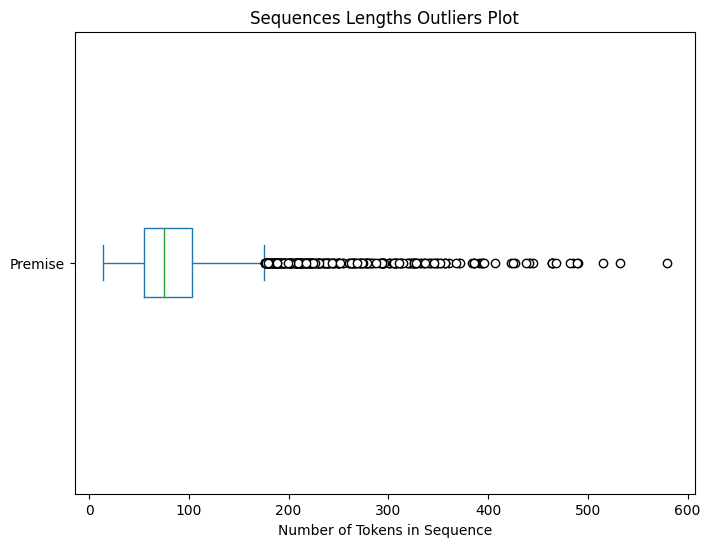

In [24]:
premises_len.plot.box(figsize=(8, 6), vert=False, flierprops={"marker": "o", "markerfacecolor": "white"})
plt.xlabel("Number of Tokens in Sequence")
plt.title("Sequences Lengths Outliers Plot")
plt.show()

In [25]:
max_length = 94   # trovare codice per percentile (99%)

### Tokenizer Initialization

In [26]:
model_names = [
              "bert-base-uncased",
              #"distilbert-base-uncased",
              #"roberta-base",
              #"distilroberta-base"
              ]

model_name = model_names[0]

In [27]:
tokenizer = AutoTokenizer.from_pretrained(model_name, truncation=True, padding=True, max_length=max_length)

### Tokenization and Conversion to DatasetDict

When `concat=True` it tokenizes the concatenation of each argument's `Premise`, `Stance` and `Conclusion`, otherwise it only tokenizes each argument's `Premise`.

Converts pandas DataFrames into a DatasetDict

        Parameters
        ----------
        train_dataframe : pd.DataFrame
            Arguments to be listed as "train"
        test_dataframe : pd.DataFrame
            Arguments to be listed as "test"
        columns : list[str]
            The labels in both DataFrames

        Returns
        -------
        tuple(DatasetDict, list[str])
            a `DatasetDict` with attributes "train" and "test" for the listed arguments,
            a `list` with the contained labels

column_intersect = [x for x in (['Premise'] + labels) if x in train_dataframe.columns.values]

In [28]:
def tokenize_and_encode(samples, concat):
  if concat:
    input_list = [samples.get(key) for key in ['Conclusion', 'Stance', 'Premise']]
    input = ' '.join(input_list)
  else:
    input_list = [samples.get(key) for key in ['Premise']]
    input = ' '.join(input_list)
  return tokenizer(input)


def convert_to_dataset(df_train, df_val, df_test, columns, concat):
    ds_train = Dataset.from_dict((df_train[columns]).to_dict('list'))
    ds_val = Dataset.from_dict((df_val[columns]).to_dict('list'))
    ds_test = Dataset.from_dict((df_test[columns]).to_dict('list')) 

    ds = DatasetDict()
    ds['train'] = ds_train
    ds['eval'] = ds_val
    ds['test'] = ds_test

    ds = ds.map(lambda x: {"labels": [float(x[c]) for c in columns[4:]]}) # put the one hot encoded row as a list in labels

    ds = ds.map(lambda x: tokenize_and_encode(x, concat), remove_columns=columns) #remove the header of the columns   
    
    return ds, columns[4:]

In [29]:
ds_no_concat, labels = convert_to_dataset(df_train, df_val, df_test, columns, concat=False)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [30]:
ds_concat, labels = convert_to_dataset(df_train, df_val, df_test, columns, concat=True)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

We choose the dataset to give in input to the model and we print out its structure.

In [31]:
# ds = ds_no_concat
ds = ds_concat
print(ds)

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5393
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1896
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 100
    })
})


### Tokenization Example

In the following example we choose a random sample from the train, validation or test encoded set and we decode it with the `decode()` function of the tokenizer. 

In [32]:
split = ['train','eval','test']
random_split = random.randint(0,2)
random_sample = random.randint(0,len(ds[split[random_split]]))

print(f'Encoded sample taken from {split[random_split]} dataset:\n', ds[split[random_split]][random_sample]["input_ids"])
decoded_sample = tokenizer.decode(ds[split[random_split]][random_sample]["input_ids"])
print(f'Decoded sample taken from {split[random_split]} dataset:\n', decoded_sample)

Encoded sample taken from eval dataset:
 [101, 15823, 14474, 6167, 3092, 2114, 15823, 14474, 15399, 22129, 2203, 7596, 4491, 6148, 3521, 3956, 102]
Decoded sample taken from eval dataset:
 [CLS] blockade gaza strip ended against blockade gaza pressures hamas end rocket attacks seek peace israel [SEP]


## Model Definition

In [33]:
num_labels = len(labels)

In [34]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=num_labels
                                                           )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [35]:
model = model.to(device)

### Model Structure

In [36]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Model Training

### Definition of the Evaluation Metrics

In [56]:
best_threshold = 0.0

In [57]:
def compute_metrics(eval_predictions):

  best_f1 = 0.0
  best_precision = 0.0
  best_recall = 0.0

  for threshold in np.arange(0.1, 0.95, 0.05):

    predictions, labels = eval_predictions

    # Normalize the predictions
    predictions = torch.from_numpy(predictions).sigmoid().numpy()

    # Convert the predicted probabilities to binary labels
    eval_preds = np.where(predictions > threshold, 1.0, 0.0)

    # Compute the evaluation metrics
    f1 = f1_score(labels, eval_preds, average='macro', zero_division=0)
    precision = precision_score(labels, eval_preds, average='macro', zero_division=0)
    recall = recall_score(labels, eval_preds, average='macro', zero_division=0)

    # Update the threshold based on the best F1 score seen so far
    if f1 > best_f1:
        best_f1 = f1
        best_precision = precision
        best_recall = recall
        global best_threshold
        best_threshold = threshold

    # Print the F1 score and threshold for each evaluation step
    # print(f'F1 score: {f1:.4f} - Threshold: {threshold:.2f}')

  print(f'Best F1 score: {best_f1:.4f} - Best Threshold: {best_threshold:.2f}')

  return {'precision': best_precision, 'recall': best_recall, 'f1': best_f1}

### Hyperparameters Definition

In [39]:
batch_size_train = 128
batch_size_eval = 128
lr = 2e-5 #1e-5
num_train_epochs = 20
weight_decay=0.1 #0.01
seed = 42

In [40]:
args = TrainingArguments(
                         model_name,
                         evaluation_strategy = "epoch",
                         save_strategy = "epoch", # parametro attivato per EarlyStopping
                         logging_strategy='epoch',
                         learning_rate=lr,
                         per_device_train_batch_size=batch_size_train,
                         per_device_eval_batch_size=batch_size_eval,
                         num_train_epochs=num_train_epochs,
                         weight_decay=weight_decay,
                         load_best_model_at_end=True, # flag attivato per EarlyStopping
                         seed=seed,
                         )

### Custom Trainer Instantiation

Customize Trainer to use a weighted loss (useful when you have an unbalanced training set):

In [41]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss = torch.nn.BCEWithLogitsLoss()(logits,labels)
        return (loss, outputs) if return_outputs else loss

The main difference between nn.CrossEntropyLoss() and nn.BCEWithLogitsLoss() for multi-label classification tasks is in their assumptions about the label encoding.

nn.CrossEntropyLoss() assumes that the labels are encoded as class indices, where each sample is associated with a single class. This means that for multi-label classification tasks, the labels need to be one-hot encoded, which can be memory-intensive and computationally expensive for large datasets with a large number of classes. Additionally, nn.CrossEntropyLoss() applies a softmax activation function to the output layer of the neural network, which can cause numerical instability and saturation when dealing with a large number of classes.

nn.BCEWithLogitsLoss(), on the other hand, assumes that the labels are encoded as binary indicators, where each sample can be associated with multiple classes. This means that the labels can be encoded as a tensor of binary values, where each element corresponds to a different class. The BCE stands for binary cross-entropy, and the WithLogits means that the function expects the output of the neural network to be unnormalized logits, rather than probabilities.

In summary, nn.CrossEntropyLoss() is appropriate for multi-class classification tasks, where each sample belongs to one and only one class, and the labels are one-hot encoded. nn.BCEWithLogitsLoss() is appropriate for multi-label classification tasks, where each sample can belong to multiple classes, and the labels are binary encoded.

In [42]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience = 3, # number of times to wait without improvement before stopping
    early_stopping_threshold = 0.001 # minimum improvement required to count as improvement
)

In [58]:
trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["eval"],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_preds: compute_metrics(eval_preds),
    callbacks=[early_stopping_callback]  # add the early stopping callback
)

Callbacks, on the other hand, are functions that are called during the training process at certain predefined points, such as at the end of an epoch or after a certain number of batches have been processed. They are used for a variety of purposes, such as monitoring the progress of the training, saving model checkpoints, early stopping, and adjusting the learning rate.

While callbacks can affect the training process and the performance of the model indirectly, they are not considered hyperparameters because they are not directly optimized or tuned during the training process.

### Training

In [44]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.537200,0.435807,0.167695,1.000000,0.271772
2,0.424400,0.407730,0.167821,0.750639,0.258326
3,0.406800,0.400588,0.187855,0.739557,0.256617
4,0.392400,0.388142,0.188328,0.747839,0.286331
5,0.378300,0.381898,0.250920,0.561799,0.304751
6,0.364900,0.373965,0.262758,0.572589,0.313015
7,0.354500,0.369877,0.265540,0.576972,0.321287
8,0.342100,0.363073,0.273258,0.557364,0.327463
9,0.334000,0.360026,0.286203,0.565195,0.338202
10,0.324900,0.358667,0.289126,0.573204,0.345802


Epoch: 1 - Best F1 score: 0.2718 - Best Threshold: 0.10
Epoch: 2 - Best F1 score: 0.2583 - Best Threshold: 0.10
Epoch: 3 - Best F1 score: 0.2566 - Best Threshold: 0.10
Epoch: 4 - Best F1 score: 0.2863 - Best Threshold: 0.10
Epoch: 5 - Best F1 score: 0.3048 - Best Threshold: 0.15
Epoch: 6 - Best F1 score: 0.3130 - Best Threshold: 0.15
Epoch: 7 - Best F1 score: 0.3213 - Best Threshold: 0.15
Epoch: 8 - Best F1 score: 0.3275 - Best Threshold: 0.15
Epoch: 9 - Best F1 score: 0.3382 - Best Threshold: 0.15
Epoch: 10 - Best F1 score: 0.3458 - Best Threshold: 0.15
Epoch: 11 - Best F1 score: 0.3493 - Best Threshold: 0.10
Epoch: 12 - Best F1 score: 0.3563 - Best Threshold: 0.15
Epoch: 13 - Best F1 score: 0.3630 - Best Threshold: 0.15
Epoch: 14 - Best F1 score: 0.3626 - Best Threshold: 0.10
Epoch: 15 - Best F1 score: 0.3622 - Best Threshold: 0.15
Epoch: 16 - Best F1 score: 0.3645 - Best Threshold: 0.15


TrainOutput(global_step=688, training_loss=0.354563973670782, metrics={'train_runtime': 1028.6009, 'train_samples_per_second': 104.861, 'train_steps_per_second': 0.836, 'total_flos': 3028291709805912.0, 'train_loss': 0.354563973670782, 'epoch': 16.0})

In [45]:
from google.colab import drive
drive.mount('/content/drive')
link = '/content/drive/MyDrive/UNIBO/NLP/STANDARD_PROJECT' 

link = link + "/" + model_name
# SAVING THE WEIGHTS OF THE MODEL 
trainer.save_model(link)

Mounted at /content/drive


Runs are evaluated on the basis of F1-score, Precision, and Recall in TIRA: averaged over all value categories and for each category individually. For the shared task leaderboard, the runs are ranked according to the averaged F1-score on the "arguments-test" dataset, corresponding to the arguments-test.tsv of the dataset.

The values of "0.00" in the classification report indicate that the model did not predict any positive examples for those particular classes. In other words, the precision, recall, and F1-score for those classes are all zero because there were no true positives or false positives predicted by the model. This can happen for a variety of reasons, such as a lack of training data for those classes or a lack of predictive power for the features associated with those classes. It's important to consider why the model is failing to predict positive examples for certain classes and whether additional data or feature engineering could improve performance on those classes.

## Evaluation

In [46]:
trainer.evaluate()

Epoch: 17 - Best F1 score: 0.3645 - Best Threshold: 0.15


{'eval_loss': 0.35500261187553406,
 'eval_precision': 0.3109380208463018,
 'eval_recall': 0.5527767822557907,
 'eval_f1': 0.3645487485736287,
 'eval_runtime': 4.6865,
 'eval_samples_per_second': 404.569,
 'eval_steps_per_second': 3.201,
 'epoch': 16.0}

## Prediction

In [47]:
test_predictions, test_ids, test_metrics = trainer.predict(ds['test'])

Epoch: 18 - Best F1 score: 0.2761 - Best Threshold: 0.25


## Inference

Prendiamo frasi random e otteniamo in output la lista di etichette assegnate a quella frase + stampa della ground truth

In [48]:
id2label = {
 0:'Self-direction: thought',
 1:'Self-direction: action',
 2:'Stimulation',
 3:'Hedonism',
 4:'Achievement',
 5:'Power: dominance',
 6:'Power: resources',
 7:'Face',
 8:'Security: personal',
 9:'Security: societal',
 10:'Tradition',
 11:'Conformity: rules',
 12:'Conformity: interpersonal',
 13:'Humility',
 14:'Benevolence: caring',
 15:'Benevolence: dependability',
 16:'Universalism: concern',
 17:'Universalism: nature',
 18:'Universalism: tolerance',
 19:'Universalism: objectivity'}

In [49]:
my_sentence = "We should legalize the use of marijuana since it is shown in scientific studies to have a beneficial effect for people with anxiety conditions."
#my_sentence = "Young people should practice more sport, in particular swimming since it is the most complete sport for good health."

def inference(my_sentence, threshold):

  device = torch.device("cuda")

  # - preprocessing mmy_sentence
  input_text = text_prepare(my_sentence)

  # - tokenize
  input_text = tokenizer(input_text, return_tensors = 'pt' ) #dizionario con key 'input_ids' 

  for key in input_text:
    input_text[key] = input_text[key].to(device)

  # - dare in input al modello
  with torch.no_grad():
    output_predictions = model(input_text['input_ids'])
    output_predictions = {key: output.cpu() for key, output in output_predictions.items()}
  
  # - ottenere predizione in output + normalizzarla + binarizzarla
  output_predictions = output_predictions['logits'].sigmoid().numpy()
  output_predictions = np.where(output_predictions > threshold, 1, 0) 

  # - usare dizionario lab2input per ottenere le etichette predette
  output_labels = np.where(output_predictions == 1) # etichette predette a 1
  
  #trasform in a list of indeces
  output_labels = output_labels[1].tolist()
  output_labels = [id2label[idx] for idx in output_labels]
  print("The predicted labels are:\n", output_labels)

In [50]:
inference(my_sentence, best_threshold)

The predicted labels are:
 ['Achievement', 'Security: personal']
